# Hilbert space approxmation gaussina process

In [16]:
import stan as ps
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from formulae import design_matrices

# Set plot style
az.style.use("arviz-white")

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

#Specify the number of chains to the number of availible cpu's.
n_chains = 4
n_samples = 500
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

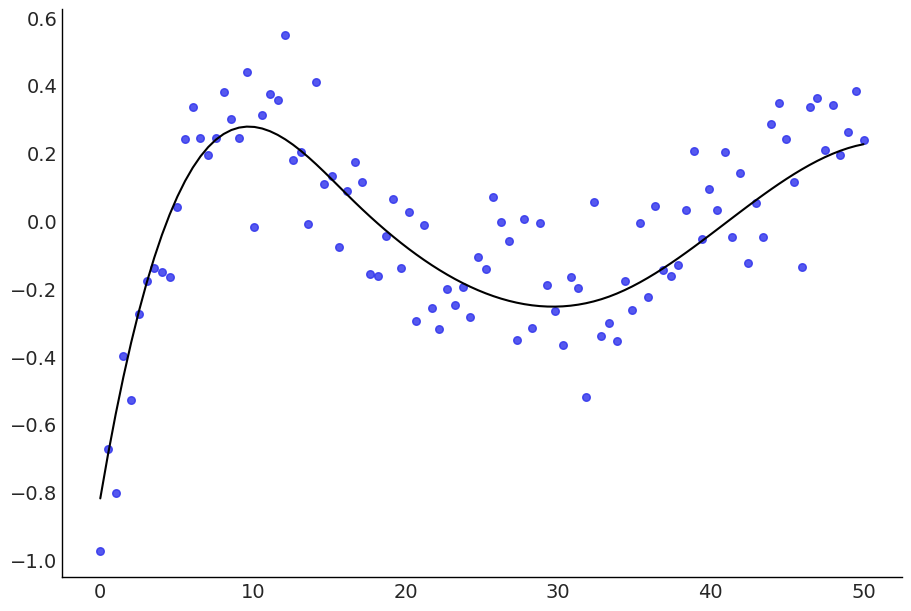

In [7]:
rng = np.random.default_rng(seed=121195)

size = 100
x = np.linspace(0, 50, size)
b = 0.1 * rng.normal(size=6)
sigma = 0.15

dm = design_matrices("0 + bs(x, df=6, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + rng.normal(size=size) * sigma
df = pd.DataFrame({"x": x, "y": y})

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [20]:
HSGP = '''
functions{
vector diagSPD_EQ(real alpha, real rho, real L, int M) {
  vector[M] one_to_M2;
  for (m in 1:M) one_to_M2[m] = m^2;
  return alpha * sqrt(sqrt(2*pi()) * rho) * exp(-0.25*(rho*pi()/2/L)^2 * one_to_M2);
}

matrix PHI(int N, int M, real L, vector x) {
  return sin(diag_post_multiply(rep_matrix(pi()/(2*L) * (x+L), M), linspaced_vector(M, 1, M)))/sqrt(L);
    }
}
data {
  int<lower=1> N;      // number of observations
  vector[N] x;         // univariate covariate
  vector[N] y;         // target variable
        
  real<lower=0> c_f1;  // factor c to determine the boundary value L
  int<lower=1> M_f1;   // number of basis functions for smooth function
}
transformed data {

  // Basis functions for f1
  real L_f1 = c_f1*max(x);
  matrix[N,M_f1] PHI_f1 = PHI(N, M_f1, L_f1, x);
}
parameters {
  vector[M_f1] beta_f1;         // the basis functions coefficients
  real<lower=0> lengthscale_f1; // lengthscale of f1
  real<lower=0> sigma_f1;       // scale of f1
  real<lower=0> sigma;          // residual scale
}
model {
  // spectral densities for f1
  vector[M_f1] diagSPD_f1 = diagSPD_EQ(sigma_f1, lengthscale_f1, L_f1, M_f1);
  // priors
  lengthscale_f1 ~ inv_gamma(10, 1);
  sigma_f1 ~ exponential(2);
  sigma ~ normal(0, 10);
  // model
  y ~ normal_id_glm(PHI_f1, 0, diagSPD_f1 .* beta_f1, sigma); 
}

'''

In [21]:
d = {"N": len(df),
     "x": df.x.values,
     "y": df.y.values,
     "c_f1": 2,
     "M_f1": 10}

In [22]:
sm = ps.build(HSGP, data = d)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 

In file included from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/functor.hpp:12,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:198,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/harrison/.cache/httpstan/4.6.1/models/fpkfed6l/model_fpkfed6l.cpp:2:
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp: In function 'void stan::math::internal::combination(std::vector<int>&, const int&, const int&, const int

Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s


In file included from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/inc

Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s


In file included from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of 'TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = double; T2 = double; T3 = double; T_z = double; ScalarT = double; TupleT = std::tuple<double, double, 

Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s


/home/harrison/.cache/httpstan/4.6.1/models/fpkfed6l/model_fpkfed6l.cpp: In instantiation of 'void model_fpkfed6l_namespace::model_fpkfed6l::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]':
/home/harrison/.cache/httpstan/4.6.1/models/fpkfed6l/model_fpkfed6l.cpp:604:27:   required from here
/home/harrison/.cache/httpstan/4.6.1/models/fpkfed6l/model_fpkfed6l.cpp:397:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
  397 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/harrison/.cache/httpstan/4.6.1/models/fpkfed6l/model_fpkfed6l.cpp: In instantiation of 'void model_fpkfed6l_namespace::model_fpkfed6l::unconstrain_array_impl(const VecVar&, const VecI&, VecVa

Building: 11.7s
Building: 11.8s


/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of 'TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]':
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from 'TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<doub

Building: 11.9s
Building: 12.0s
Building: 12.1s


In file included from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err.hpp:4,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:8:
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/elementwise_check.hpp: In instantiation of '

Building: 12.2s
Building: 12.3s


/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/elementwise_check.hpp: In instantiation of 'void stan::math::elementwise_check(const F&, const char*, const char*, const T&, const char*, const Indexings& ...) [with F = check_finite<Eigen::Matrix<double, 2, 1> >(const char*, const char*, const Eigen::Matrix<double, 2, 1>&)::<lambda(double)>; T = Eigen::Matrix<double, 2, 1>; Indexings = {}; stan::require_eigen_t<S>* <anonymous> = 0; std::enable_if_t<((Eigen::internal::traits<_Rhs>::Flags & Eigen::LinearAccessBit) || T::IsVectorAtCompileTime)>* <anonymous> = 0]':
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/check_finite.hpp:29:20:   required from 'void stan::math::check_finite(const char*, const char*, const T_y&) [with T_y = Eigen::Matrix<double, 2, 1>]'
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/hypergeometri

Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s


/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/elementwise_check.hpp: In instantiation of 'void stan::math::elementwise_check(const F&, const char*, const char*, const T&, const char*, const Indexings& ...) [with F = check_finite<Eigen::Map<Eigen::Matrix<double, -1, 1>, 0, Eigen::Stride<0, 0> > >(const char*, const char*, const Eigen::Map<Eigen::Matrix<double, -1, 1>, 0, Eigen::Stride<0, 0> >&)::<lambda(double)>; T = Eigen::Map<Eigen::Matrix<double, -1, 1>, 0, Eigen::Stride<0, 0> >; Indexings = {}; stan::require_eigen_t<S>* <anonymous> = 0; std::enable_if_t<((Eigen::internal::traits<_Rhs>::Flags & Eigen::LinearAccessBit) || T::IsVectorAtCompileTime)>* <anonymous> = 0]':
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/err/check_finite.hpp:29:20:   required from 'void stan::math::check_finite(const char*, const char*, const T_y&) [with T_y = Eigen::Map<Eigen::Matrix<double, -1

Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building

Building: 25.4s, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [23]:
fit = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS )

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   3% (101/3000)
Sampling:   7% (201/3000)
Sampling:  10% (301/3000)
Sampling:  17% (500/3000)
Sampling:  38% (1150/3000)
Sampling:  60% (1800/3000)
Sampling:  82% (2450/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/tmp/httpstan_h_qmghjc/model_fpkfed6l.stan', line 41, column 2 to column 61)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned

In [24]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_f1[0],-3150413.418,3975345.940,-1.137888e+07,1.033685e+06,1886074.009,1432563.784,5.0,11.0,2.31
beta_f1[1],-3097705.820,4555659.691,-1.090465e+07,3.852975e+06,2140747.715,1623587.304,5.0,11.0,2.80
beta_f1[2],2422838.384,1758829.834,-3.222029e+05,6.350957e+06,680982.277,525429.154,8.0,18.0,1.50
beta_f1[3],737843.443,2441131.304,-3.136696e+06,5.561709e+06,1092165.932,822471.338,5.0,11.0,2.43
beta_f1[4],-854840.859,2546619.231,-4.613856e+06,4.207800e+06,1098245.791,823091.066,6.0,14.0,1.78
beta_f1[5],-2506512.850,1677713.291,-6.114002e+06,-3.206753e+05,742709.734,558512.469,6.0,16.0,1.96
beta_f1[6],1310073.705,2923584.997,-2.640672e+06,7.856638e+06,1376026.583,1043863.642,5.0,14.0,2.54
beta_f1[7],5773846.695,4202068.444,2.537806e+05,1.495769e+07,1933712.709,1461997.069,5.0,11.0,2.05
beta_f1[8],5128048.967,3390440.423,6.466089e+05,1.219926e+07,1581306.162,1197933.721,5.0,11.0,2.28
beta_f1[9],2327202.226,1623790.267,3.252219e+05,5.642878e+06,732536.860,552277.161,5.0,11.0,2.10
